In [18]:
import osmread
import numpy as np
import leuvenmapmatching
from pathlib import Path
import requests
import rtree
import pyproj
import matplotlib.pyplot as plt
import networkx as nx
import math
import random
import logging
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import smopy
import pandas as pd
from pathlib import Path
import requests
import geocoder

In [2]:
from leuvenmapmatching.map.inmem import InMemMap
from leuvenmapmatching.matcher.distance import DistanceMatcher
from leuvenmapmatching.util.gpx import gpx_to_path
from leuvenmapmatching import visualization as mmviz
from leuvenmapmatching import visualization as mm_viz

In [19]:
g = geocoder.osm('UFA, Russia')
print('Lat: {}\nLong: {}'.format(g.osm['y'], g.osm['x']))

Lat: 54.7261409
Long: 55.947499


In [69]:
# парсим XML файл с OpenStreepMap через API

xml_file = Path(".") / "my_osm.xml"
url = 'http://overpass-api.de/api/map?bbox=55.852830,54.690987,55.862870, 54.700228'
r = requests.get(url, stream=True)
with xml_file.open('wb') as ofile:
    for chunk in r.iter_content(chunk_size=1024):
        if chunk:
            ofile.write(chunk)

In [70]:
# выбраем дороги, которые мы хотим использовать для создания ориентированного графа. Дороги с тегом «highway». 

map_con = InMemMap("myosm", use_latlon=True, use_rtree=True, index_edges=True)
for entity in osmread.parse_file(str(xml_file)):
    if isinstance(entity, osmread.Way) and 'highway' in entity.tags:
        for node_a, node_b in zip(entity.nodes, entity.nodes[1:]):
            map_con.add_edge(node_a, node_b)
            # Добавляем направления дорог
            map_con.add_edge(node_b, node_a)
    if isinstance(entity, osmread.Node):
        map_con.add_node(entity.id, (entity.lat, entity.lon))
map_con.purge()

In [80]:
#GPS трек
track = [(54.698244, 55.855948),(54.698159, 55.855787), (54.698087, 55.855772),(54.697994, 55.855757),(54.697922, 55.855735),(54.697858, 55.855838),(54.697778, 55.855714), (54.697701, 55.855794),(54.697672, 55.855640), (54.697701, 55.855472),(54.697714, 55.855209),(54.697638, 55.855114),(54.697579, 55.855092),(54.697451, 55.855092),(54.697502, 55.854843),(54.697468, 55.854690),(54.697485, 55.854565)]

In [81]:
# Расчет расстояния и выбор ближащего подходящего ребра из графа местности.
matcher = DistanceMatcher(map_con, max_dist=100, max_dist_init=25, min_prob_norm=0.001, non_emitting_length_factor=0.75, obs_noise=50, obs_noise_ne=75, dist_noise=50, non_emitting_states=True)
states, lastidx = matcher.match(track)

(None, <AxesSubplot:xlabel='Longitude', ylabel='Latitude'>)

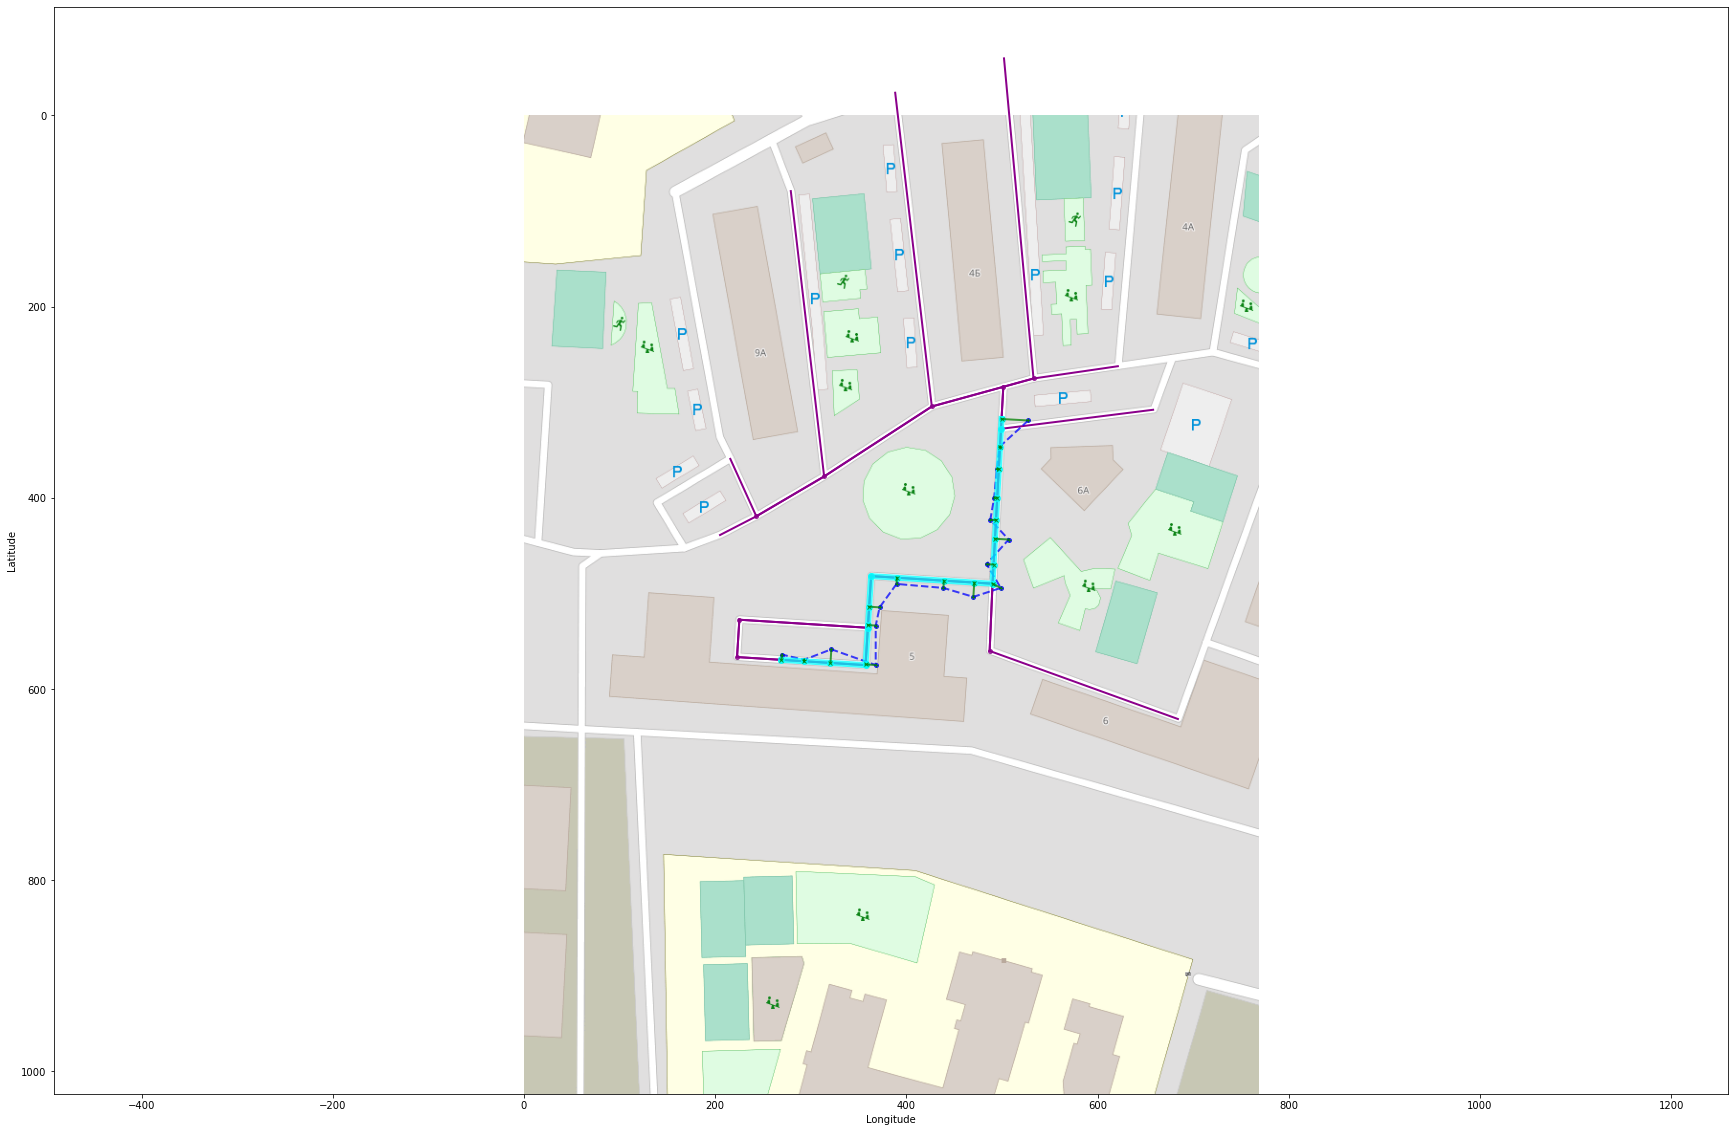

In [82]:
# визуализация метода (зеленые проектции на ребра наиболее вероятного графа дороги), отображение маршрута (светло-синий) и графов (фиолетовый) дорог на карте OSM

fig, ax = plt.subplots(figsize = (30,20))
mmviz.plot_map(map_con,matcher=matcher,
                use_osm=True, zoom_path=True, ax=ax,
                show_labels=False, show_matching=True, show_graph=True,
                filename="example_5_osm_plot.png")